### Covid-19 Infection Counts Exploration
* author   : santosh
* date     : 05.04.2020
* purpose  : run country level trends (Infections, Recovery, Deaths, CFR)
* instance : local

<font color='tan'> setup

In [1]:
#import dependencies
#data wrangling
import numpy as np
import pandas as pd
import dfply as dfp
import datetime as dt
#plot
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sb
#helper funcs
from helper_funcs import isUnique

In [2]:
#display options
pd.options.display.html.table_schema = True
pd.set_option('display.max_rows', 999)
# %matplotlib inline

<font color='tan'> ingest scrubbed analysis data

In [3]:
#read csv file
country_df = pd.read_csv('../data/covid19_country_analysis_data.csv', sep=',', parse_dates=['Date'])

In [4]:
#check dtypes
country_df.dtypes

Confirmed                  int64
Confirmed_New            float64
Country_Region            object
Date              datetime64[ns]
Deaths                     int64
Deaths_New               float64
Recovered                  int64
Recovered_New            float64
year                       int64
month                      int64
year_month                object
dtype: object

In [5]:
#ensure counts are not below zero
country_df['Confirmed_New'] = country_df['Confirmed_New'].apply(lambda x:max(0,x))
country_df['Deaths_New'] = country_df['Deaths_New'].apply(lambda x:max(0,x))
country_df['Recovered_New'] = country_df['Recovered_New'].apply(lambda x:max(0,x))

In [6]:
#check uniqueness
print('\nanalysis data unique in Country and Date: ',isUnique(country_df, ['Country_Region','Date']))


analysis data unique in Country and Date:  True


<font color='tan'> user inputs for cumulative & daily trends

In [7]:
#user input - number of countries to display
topsel = input('Choose number of countries you want to display: enter a number b.w. 1 and 10')
print('\nyou chose: ',topsel)

Choose number of countries you want to display: enter a number b.w. 1 and 105

you chose:  5


In [8]:
#user input - metric to plot
metric_cum = input("Choose the cumulative Covid-19 metric you want: 'Confirmed','Deaths' or 'Recovered'")
print('\nyou chose: ',metric_cum)

Choose the cumulative Covid-19 metric you want: 'Confirmed','Deaths' or 'Recovered'Confirmed

you chose:  Confirmed


In [9]:
#choose metric
metric_new = input("Choose the daily Covid-19 metric you want: 'Confirmed_New','Deaths_New' or 'Recovered_New'")
print('\nyou chose: ',metric_new)

Choose the daily Covid-19 metric you want: 'Confirmed_New','Deaths_New' or 'Recovered_New'Confirmed_New

you chose:  Confirmed_New


In [10]:
#create list of top countries (with and without US)
topnum = int(topsel) #select how many countries to display

#including US
top = country_df.groupby(['Country_Region'],as_index=False)\
.agg({metric_cum:'max'})\
.sort_values(by=[metric_cum], ascending=False)\
.head(topnum)['Country_Region']\
.tolist()

#excluding US
top_xus = country_df.loc[country_df['Country_Region'] != 'US']\
.groupby(['Country_Region'],as_index=False)\
.agg({metric_cum:'max'})\
.sort_values(by=[metric_cum], ascending=False)\
.head(topnum)['Country_Region']\
.tolist()

In [11]:
#user input - select 'top' or 'top_xus'
list_sel = top
#list_sel = top_xus

<font color='tan'> plot cumulative trends

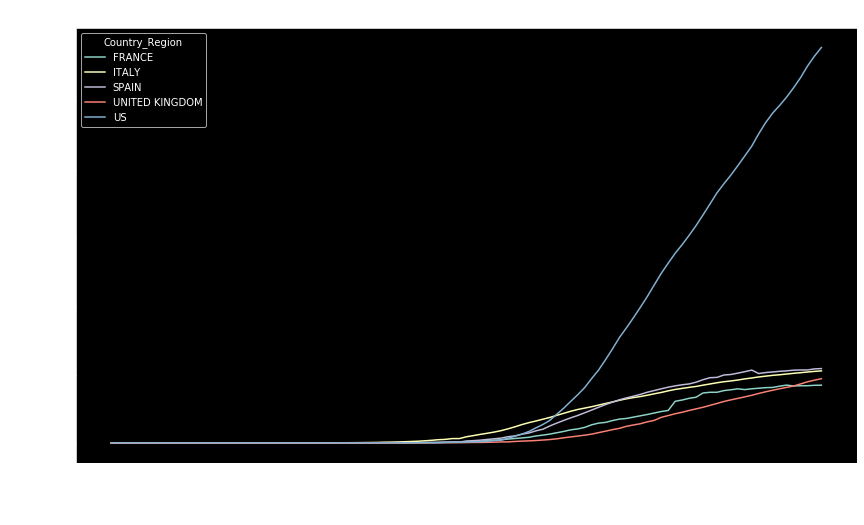

In [12]:
#filter and transpose data
p_df = country_df.loc[country_df['Country_Region'].isin(list_sel)]\
.pivot_table(values=metric_cum, index=['Date'], columns='Country_Region')\
.reset_index().fillna(0)
p_df.set_index('Date', inplace=True)

#plot
p_df.plot.line(figsize=(14,8))
plt.title('Cumulative Covid-19 trends: '+metric_cum, size=20)
plt.xlabel('Date',size=14)
plt.xticks(size=14, color='white')
plt.yticks(size=14, color='white')
plt.show()

<font color='tan'> plot daily trends

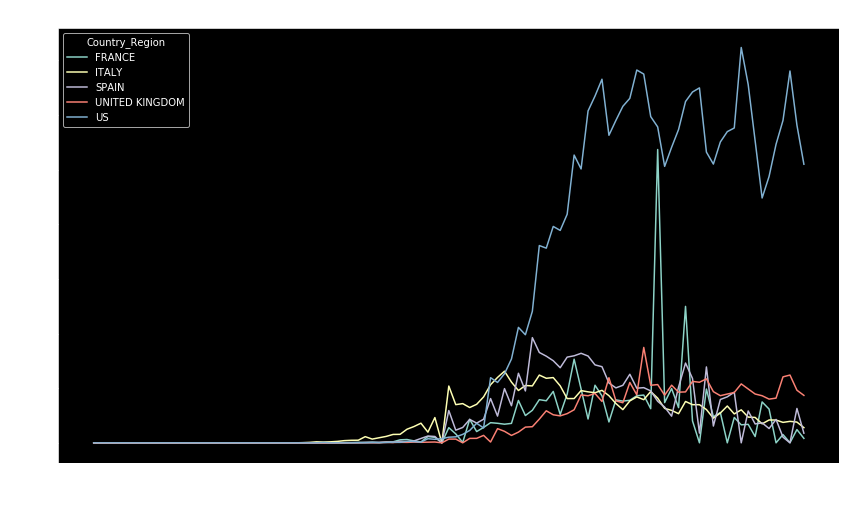

In [13]:
#filter and transpose data
p_df = country_df.loc[country_df['Country_Region'].isin(list_sel)]\
.pivot_table(values=metric_new, index=['Date'], columns='Country_Region')\
.reset_index().fillna(0)
p_df.set_index('Date', inplace=True)

#plot
p_df.plot.line(figsize=(14,8))
plt.title('Daily Covid-19 trends: '+metric_new, size=20)
plt.xlabel('Date',size=14)
plt.xticks(size=14, color='white')
plt.yticks(size=14, color='white')
plt.show()

<font color='tan'> add trendline to daily new cases

In [14]:
p_df = country_df.loc[country_df['Country_Region'].isin(list_sel)]
p_df['days_since_jan22'] = (p_df['Date'] - p_df['Date'].min()).dt.days
#plot
def getTrend(country):
    """
    returns a seaborn lmplot of daily metric
    """
    df = p_df.loc[p_df['Country_Region'] == country]
    sb.lmplot(x='days_since_jan22', y=metric_new, data=df, lowess=True, aspect=20/9, line_kws={'color': 'red'})
    plt.title(' Daily Covid-19 cases: '+country+' : '+metric_new, size=20)
    plt.xlabel('Days since Jan-22', size=14)
    plt.xticks(size=14, color='white')
    plt.yticks(size=14, color='white') 
    plt.show()

/Users/santossa/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


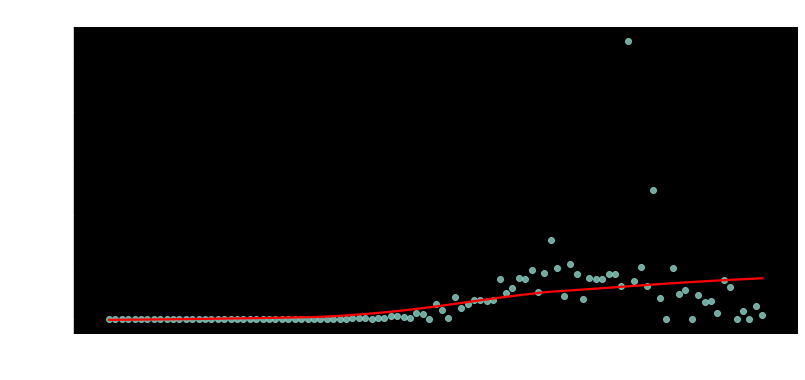

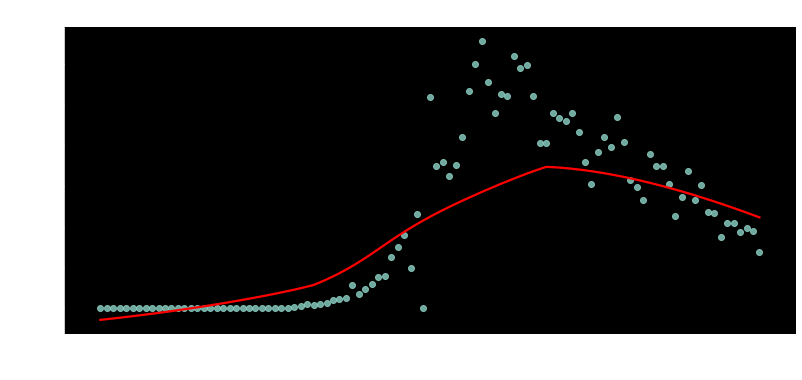

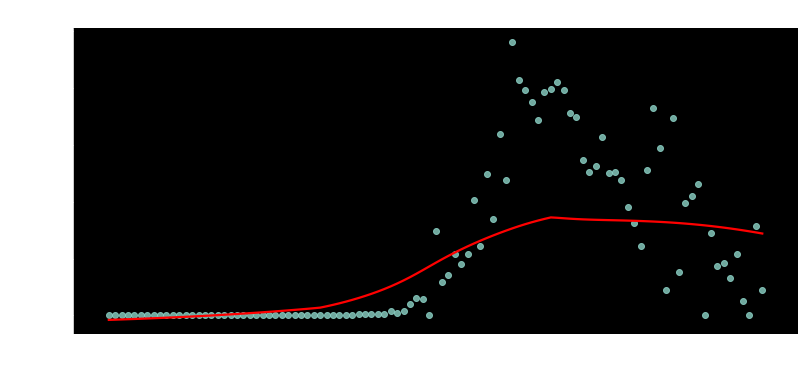

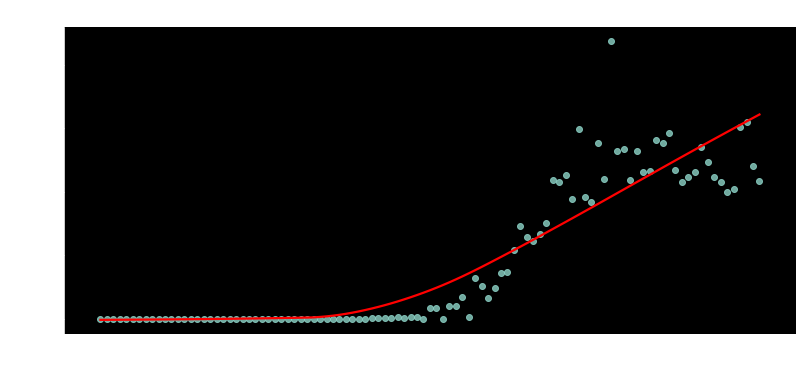

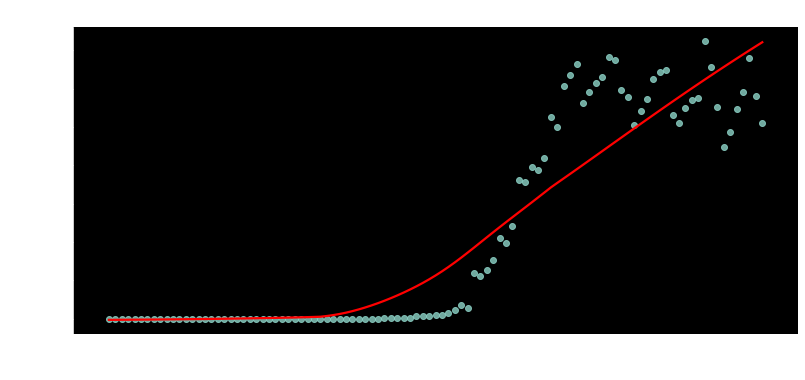

In [15]:
list_country = p_df['Country_Region'].unique()
for item in list_country:
    getTrend(item)

<font color='tan'> compute CFR

In [49]:
#aggregate across months
cfr_df = country_df.groupby(['Country_Region'])\
.agg({'Confirmed_New':'sum','Deaths_New':'sum'})\
.reset_index()

cfr_df.rename(columns={'Confirmed_New':'Cum_inf','Deaths_New':'Cum_dth'}, inplace=True)

print('cfr_df unique in Country: ', isUnique(cfr_df, ['Country_Region']))

#compute CFR
cfr_df['CFR'] = cfr_df['Cum_dth'] / cfr_df['Cum_inf']

cfr_df unique in Country:  True


In [50]:
#filter for countries with at least 1000 infections
cfr_df = cfr_df.loc[cfr_df['Cum_inf'] >= 1000]\
.sort_values(by=['CFR'], ascending=False).reset_index()
cfr_df['CFR_rank'] = cfr_df.index.values + 1

#display top 25 countries by CFR
cfr_df.head(25)

,index,Country_Region,Cum_inf,Cum_dth,CFR,CFR_rank
0,16,BELGIUM,49906.0,7844.0,0.157175,1
1,176,UNITED KINGDOM,187842.0,28520.0,0.151830,2
2,62,FRANCE,173623.0,24900.0,0.143414,3
3,85,ITALY,210717.0,28884.0,0.137075,4
4,121,NETHERLANDS,40769.0,5072.0,0.124408,5
5,161,SWEDEN,22317.0,2679.0,0.120043,6
6,77,HUNGARY,2998.0,340.0,0.113409,7
7,157,SPAIN,227500.0,25264.0,0.111051,8
8,2,ALGERIA,4474.0,463.0,0.103487,9
9,111,MEXICO,23471.0,2154.0,0.091773,10


In [71]:
#spot check
print('\nTotal number of countries: ', cfr_df['CFR_rank'].max())

country = 'SINGAPORE' #select country of choice
cfr_df.loc[cfr_df['Country_Region'] == country][['Country_Region','CFR','CFR_rank']]


Total number of countries:  89


,Country_Region,CFR,CFR_rank
87,SINGAPORE,0.000989,88


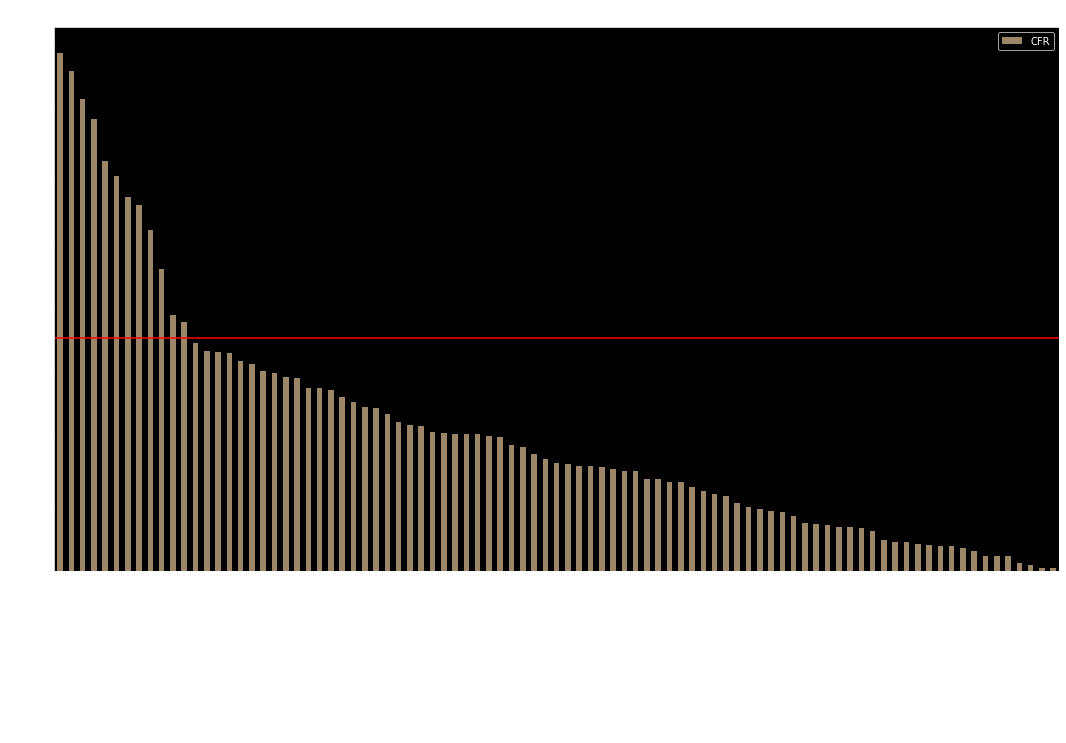

In [72]:
#plot Case Fatality Rates
cfr_df.sort_values(by=['CFR'], ascending=False)\
.plot.bar(x='Country_Region', y='CFR', figsize=(18,10), color='tan',alpha=0.75)
plt.axhline(y=cfr_df.Cum_dth.sum()/cfr_df.Cum_inf.sum(), color = 'r')
plt.title('Case Fatality Rates by Country vs. Global Avg.', size=20)
plt.xlabel('Country', size=14)
plt.ylabel('CFR (%)',size=14)
plt.show()

<font color='tan'> end